In [1]:
import glob, os
import fnmatch
import sys
import astropy
import json
import parsnip
import pandas as pd
from matplotlib import pyplot as plt
import csv
import lcdata
from astropy.table import Table, vstack
import numpy as np
from astropy.io.misc.hdf5 import write_table_hdf5
import random
import itertools
from multiprocessing import Pool


In [2]:
#get 20 random observational light curve samples to look at, randomly choose ones with 5 or more observations. only run if you want to get a figure with comparisons 
#between 20 light curves
def get_random_files(directory_path, num_files):
    try:
        file_list = [file for file in os.listdir(directory_path) if file.endswith('.hdf5') and file != 'A202210060344377m154246.hdf5']
        lcdata_objects = [lcdata.read_hdf5(os.path.join(directory_path, file)) for file in file_list]
        lcdata_list = [objects for objects in lcdata_objects if (len(objects.light_curves[0]) >= 5)]
        random_files = random.sample(lcdata_list, min(num_files, len(lcdata_list)))
        # print(lcs)
        return random_files
    except Exception as e:
        print(f'Exception on a file in dataset {directory_path}: {e}')
#get 20 observational light curve samples to look at 
data_2021 = '/global/cfs/cdirs/m4237/desirt/2021_data/lcdata/'
DCDE_data = '/global/cfs/cdirs/m4237/desirt/new_data/DCDE/'
DCDE2_data = '/global/cfs/cdirs/m4237/desirt/new_data/DCDE2/'
DCDE3_data = '/global/cfs/cdirs/m4237/desirt/new_data/DCDE3/'
DCDE4_data = '/global/cfs/cdirs/m4237/desirt/new_data/DCDE4/'

dataset = []
dataset.append(get_random_files(DCDE_data, 4))
dataset.append(get_random_files(data_2021, 4))
dataset.append(get_random_files(DCDE2_data, 4))
dataset.append(get_random_files(DCDE3_data, 4))
dataset.append(get_random_files(DCDE4_data, 4))
# print(dataset)
# flatten the dataset


In [3]:
#just generally pretty light curve for quick checking by eye
good_dataset = lcdata.read_hdf5('/global/cfs/cdirs/m4237/desirt/2021_data/lcdata/T202103221404394p014626.hdf5')

In [4]:
#100 epoch trained linear model w/out cadence cuts (flawed linear model)
model_linear_100 = parsnip.load_model('/global/cfs/cdirs/m4237/eliseke/parsnip/models/parsnip-elasticc-extragal4.pt')

/global/homes/e/eliseke/.conda/envs/parsnip_env/lib/python3.11/site-packages/parsnip/parsnip.py:297: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /opt/conda/conda-bld/pytorch_1682343970094/work/torch/csrc/utils/tensor_new.cpp:245.)
  self.band_interpolate_weights = torch.FloatTensor(band_weights).to(self.device)


In [5]:
#load in cdf models 
model_cdf_300 = parsnip.load_model("/global/cfs/cdirs/m4237/eliseke/parsnip/models/parsnip_elasticc_cdf_noise_300.pt")
model_cdf_350 = parsnip.load_model("/global/cfs/cdirs/m4237/eliseke/parsnip/models/parsnip_elasticc_cdf_noise_350.pt")
model_cdf_370 = parsnip.load_model("/global/cfs/cdirs/m4237/eliseke/parsnip/models/parsnip_elasticc_cdf_noise_370.pt")
model_cdf_410 = parsnip.load_model("/global/cfs/cdirs/m4237/eliseke/parsnip/models/parsnip_elasticc_cdf_noise_410.pt")

In [6]:
#load in linear models
linear_model_180 = parsnip.load_model('/global/cfs/cdirs/m4237/eliseke/parsnip/models/parsnip_elasticc_linear_noise_180.pt')
linear_model_230 = parsnip.load_model('/global/cfs/cdirs/m4237/eliseke/parsnip/models/parsnip_elasticc_linear_noise_230.pt')
linear_model_268 = parsnip.load_model('/global/cfs/cdirs/m4237/eliseke/parsnip/models/parsnip_elasticc_linear_noise_268.pt')
linear_model_407 = parsnip.load_model('/global/cfs/cdirs/m4237/eliseke/parsnip/models/parsnip_elasticc_linear_noise.pt')

In [7]:
#load in plasticc and Kostya's elasticc models
plasticc_model = parsnip.load_model('plasticc')
elasticc_only = parsnip.load_model('/global/cfs/cdirs/m4237/eliseke/parsnip/models/kostya_elasticc_extragal.pt')

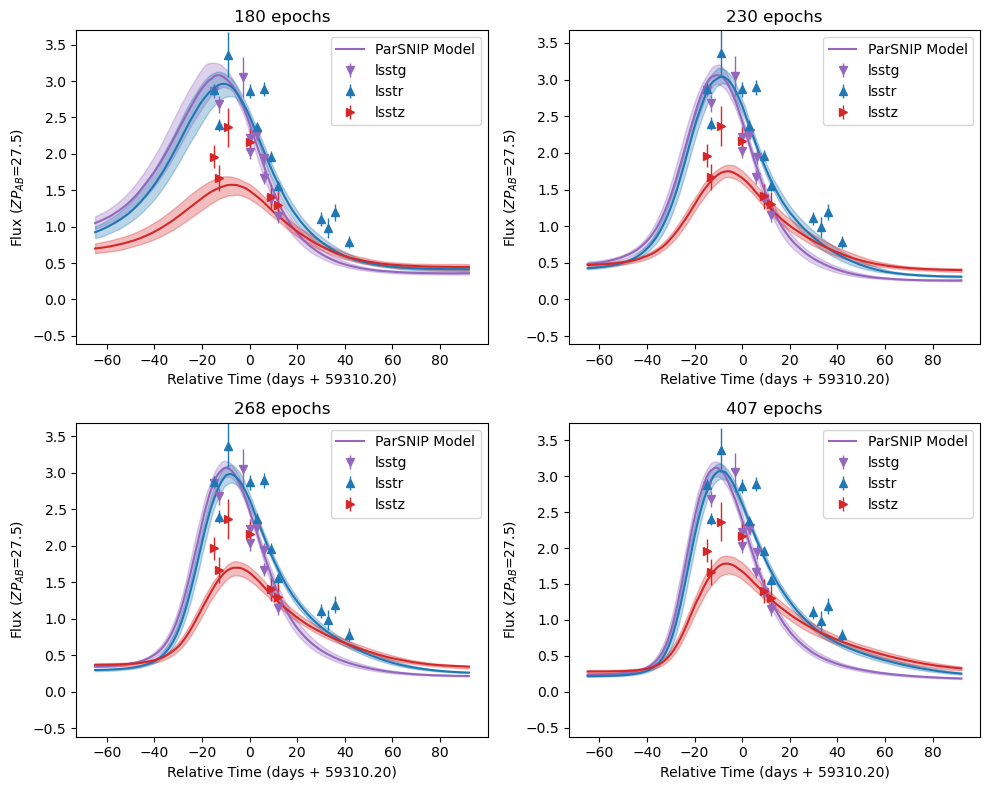

In [8]:
def compare_epochs(models, num_epochs, good_dataset):
    #create a figure that compares different epochs. can input any size list of models and it'll make a 2 row plot of how it compares
    assert len(models) == len(num_epochs), 'make sure you have a corresponding epoch label for each input model'

    num_models = len(models)
    rows = 2
    if len(models) > 10:
        rows = 3
    cols = (num_models + 1) // rows  # rounds up if there's an odd number of models

    fig, axes = plt.subplots(rows, cols, figsize=(cols*5, rows*4))

    for i, (model, epochs) in enumerate(zip(models, num_epochs)):
        row = i // cols
        col = i % cols

        parsnip.plot_light_curve(good_dataset.light_curves[0], model, ax=axes[row][col])
        axes[row][col].set_title(f'{epochs} epochs')

    plt.tight_layout()
compare_epochs([linear_model_180,linear_model_230, linear_model_268, linear_model_407], [180, 230, 268, 407], good_dataset)

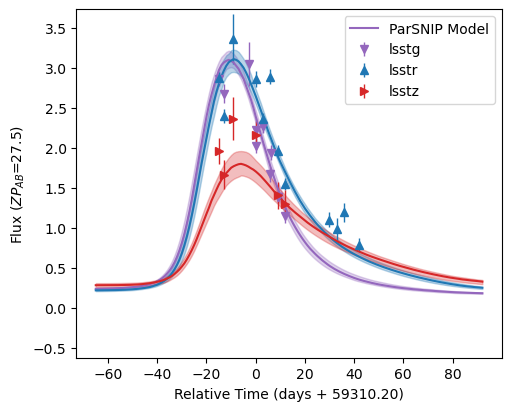

In [10]:
parsnip.plot_light_curve(good_dataset.light_curves[0], linear_model_407)

In [11]:
#function to plot 20 light curves for given model
def plot_20_lcs(model, dataset, name, save=True):
    fig, ax = plt.subplots(5, 4, figsize = (18, 20))
    parsnip.plot_light_curve(dataset[0][0].light_curves[0], model, ax = ax[0][0])
    parsnip.plot_light_curve(dataset[0][1].light_curves[0], model, ax = ax[0][1])
    parsnip.plot_light_curve(dataset[0][2].light_curves[0], model, ax = ax[0][2])
    parsnip.plot_light_curve(dataset[0][3].light_curves[0], model, ax = ax[0][3])

    parsnip.plot_light_curve(dataset[1][0].light_curves[0], model, ax = ax[1][0])
    parsnip.plot_light_curve(dataset[1][1].light_curves[0], model, ax = ax[1][1])
    parsnip.plot_light_curve(dataset[1][2].light_curves[0], model, ax = ax[1][2])
    parsnip.plot_light_curve(dataset[1][3].light_curves[0], model, ax = ax[1][3])

    parsnip.plot_light_curve(dataset[2][0].light_curves[0], model, ax = ax[2][0])
    parsnip.plot_light_curve(dataset[2][1].light_curves[0], model, ax = ax[2][1])
    parsnip.plot_light_curve(dataset[2][2].light_curves[0], model, ax = ax[2][2])
    parsnip.plot_light_curve(dataset[2][3].light_curves[0], model, ax = ax[2][3])

    parsnip.plot_light_curve(dataset[3][0].light_curves[0], model, ax = ax[3][0])
    parsnip.plot_light_curve(dataset[3][1].light_curves[0], model, ax = ax[3][1])
    parsnip.plot_light_curve(dataset[3][2].light_curves[0], model, ax = ax[3][2])
    parsnip.plot_light_curve(dataset[3][3].light_curves[0], model, ax = ax[3][3])

    parsnip.plot_light_curve(dataset[4][0].light_curves[0], model, ax = ax[4][0])
    parsnip.plot_light_curve(dataset[4][1].light_curves[0], model, ax = ax[4][1])
    parsnip.plot_light_curve(dataset[4][2].light_curves[0], model, ax = ax[4][2])
    parsnip.plot_light_curve(dataset[4][3].light_curves[0], model, ax = ax[4][3])
    plt.tight_layout()
    
    if save:
        fig.savefig(f'plots/20_{str(name)}.jpeg')

In [12]:
# plot_20_lcs(elasticc_only, dataset, 'kostya_elasticc')

In [13]:
obs = ['SNIa-SALT3', 'SNIb+HostXT_V19','SLSN-I+host', 'SNIcBL+HostXT_V19', 'SNIb-Templates', 
       'SNIIb+HostXT_V19', 'KN_K17', 'SNIax', 'TDE', 'SNIIn-MOSFIT', 'SNII-NMF', 'SNIa-91bg', 
       'SNII-Templates', 'SNIIn+HostXT_V19', 'KN_B19', 'SNII+HostXT_V19', 
       'SNIc-Templates', 'SNIc+HostXT_V19']
#cut out 'SLSN-I_no_host' and in new_names SLSN
#could be because there's no redshift. this just means that we could just remove this dataset if we have all redshifts... but if we do we need to predict redshift


In [14]:
#names to assign to each observation (categories are KN, SLSN-I, SNII, SNIIb, SNIa, SNIa-91, SNIax, SNIb, SNIc, TDE)
new_names =['SNIa', 'SNIb','SLSN-I', 'SNIc', 'SNIb', 
       'SNIIb', 'KN', 'SNIax', 'TDE', 'SNII', 'SNII', 'SNIa-91bg', 
       'SNII', 'SNII', 'KN', 'SNII', 
       'SNIc', 'SNIc']

In [41]:
#names to assign each observation when categories are SNIa, TDE, KN, SLSN, CCSN (core-collapsed supernovae)
new_names =['SNIa', 'CCSN','SLSN-I', 'CCSN', 'CCSN', 
       'CCSN', 'KN', 'SNIa', 'TDE', 'CCSN', 'CCSN', 'SNIa', 
       'CCSN', 'CCSN', 'KN', 'CCSN', 
       'CCSN', 'CCSN']

In [15]:
print(len(obs), len(new_names))

18 18


In [17]:
def produce_predictions(obj_name, new_name, filepath='/global/cfs/cdirs/m4237/desirt/Elasticc_data/Elasticc_updated_lcdata/noisy_with_cuts2/', 
                        model=model_cdf_370):
    """
    Get predictions for a given list of objects with name assigning so that the 'type' column is filled in correctly.

    Parameters:
        obj_name (str): The list of object names inside the specified `filepath` to predict from.
        new_name (str): The type/classification for each object in the predictions.
        filepath (str, optional): The file path where the data to predict from is located. 
        model (object, optional): The predictive model used to get the predictions. 

    Returns:
        pandas.DataFrame: A DataFrame containing the predictions for the given objects with an added 'type' column for the corresponding classifications.
    """
    # read the data from the specified filepath for the given list of object names
    dataset = lcdata.read_hdf5(f'{filepath}{obj_name}.hdf5')

    # get predictions from the model for the given dataset
    prediction = model.predict_dataset(dataset)

    # assign the new_name to the 'type' column for each object in the predictions
    prediction['type'] = new_name

    # return the DataFrame with predictions and 'type' column filled in correctly
    return prediction


In [19]:
#generate predictions without multiprocessing
predictions_tables = []
for i in range(len(obs)):
    table = produce_predictions(obs[i], new_names[i], filepath='/global/cfs/cdirs/m4237/desirt/Elasticc_data/Elasticc_updated_lcdata/noisy_with_cuts/', model=linear_model_407)
    predictions_tables.append(table)
    #write_table_hdf5(table, f'/global/cfs/cdirs/m4237/eliseke/parsnip/predictions_linear/{obs[i]}_predict.hdf5', serialize_meta=True, overwrite=True)

Preprocessing dataset:  86%|████████▋ | 52433/60754 [00:33<00:04, 1958.73it/s]

Preprocessing dataset:   3%|▎         | 1409/46262 [00:00<00:22, 1966.94it/s]

Preprocessing dataset:  17%|█▋        | 7809/46262 [00:05<00:23, 1621.45it/s]

Preprocessing dataset:  18%|█▊        | 8193/46262 [00:05<00:19, 1919.92it/s]

Preprocessing dataset:  52%|█████▏    | 23978/46262 [00:14<00:09, 2291.80it/s]

Preprocessing dataset: 100%|██████████| 15338/15338 [00:09<00:00, 1617.85it/s]


/global/homes/e/eliseke/.conda/envs/parsnip_env/lib/python3.11/site-packages/astropy/table/table.py:1920: StringTruncateWarning: truncated right side string(s) longer than 7 character(s) during assignment
  self.columns[item][:] = value


Preprocessing dataset: 100%|██████████| 35988/35988 [00:20<00:00, 1761.24it/s]


In [23]:
elasticc_predictions = vstack(predictions_tables)

In [24]:
#update object id columns
elasticc_predictions['original_object_id'] = elasticc_predictions['object_id']

In [25]:
#save predictions
write_table_hdf5(elasticc_predictions, '/global/cfs/cdirs/m4237/eliseke/parsnip/predictions/linearmodel_predictions.hdf5', overwrite=True,serialize_meta=True)

In [26]:
#train classifier without using luminosity or luminosity error as keys
classifier_elasticc = parsnip.Classifier()
classifier_elasticc.keys =['color', 'color_error', 's1', 's1_error', 's2', 's2_error', 's3', 's3_error', 'reference_time_error']
classifications_elasticc_train = classifier_elasticc.train(elasticc_predictions)

Training classifier with keys:
    color
    color_error
    s1
    s1_error
    s2
    s2_error
    s3
    s3_error
    reference_time_error


/global/homes/e/eliseke/.conda/envs/parsnip_env/lib/python3.11/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[100]	valid_0's multi_logloss: 1.40267


/global/homes/e/eliseke/.conda/envs/parsnip_env/lib/python3.11/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[100]	valid_0's multi_logloss: 1.42699


/global/homes/e/eliseke/.conda/envs/parsnip_env/lib/python3.11/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[100]	valid_0's multi_logloss: 1.45224


/global/homes/e/eliseke/.conda/envs/parsnip_env/lib/python3.11/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[100]	valid_0's multi_logloss: 1.46303


/global/homes/e/eliseke/.conda/envs/parsnip_env/lib/python3.11/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[100]	valid_0's multi_logloss: 1.44619


/global/homes/e/eliseke/.conda/envs/parsnip_env/lib/python3.11/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[100]	valid_0's multi_logloss: 1.45704


/global/homes/e/eliseke/.conda/envs/parsnip_env/lib/python3.11/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[100]	valid_0's multi_logloss: 1.45401


/global/homes/e/eliseke/.conda/envs/parsnip_env/lib/python3.11/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[100]	valid_0's multi_logloss: 1.43066


/global/homes/e/eliseke/.conda/envs/parsnip_env/lib/python3.11/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[100]	valid_0's multi_logloss: 1.44018


/global/homes/e/eliseke/.conda/envs/parsnip_env/lib/python3.11/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[100]	valid_0's multi_logloss: 1.42951


In [27]:
#to test the trained classifier
classifications_elasticc_test = classifier_elasticc.classify(elasticc_predictions)

Macro averaged completeness (Villar et al. 2020): 0.5057
Fraction correct: 0.4761


<Axes: title={'center': 'ELAsTiCC $-$ ParSNIP'}, xlabel='Predicted Type', ylabel='True Type'>

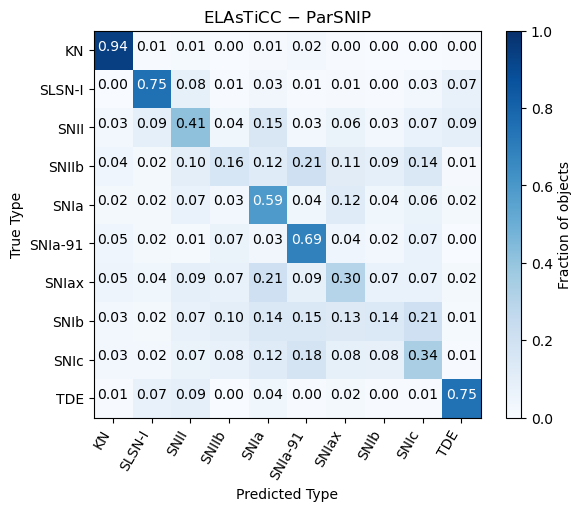

In [28]:
#plot confusion matrix
parsnip.plot_confusion_matrix(elasticc_predictions, 
                              classifications_elasticc_test, 
                              figsize=(6, 5), title='ELAsTiCC $-$ ParSNIP')

In [76]:
print(classifications_elasticc_test['SNIa'])

        SNIa        
--------------------
0.023689361955554766
   0.557439963933507
  0.5081394423153592
  0.8712482856796155
  0.7606041212452297
 0.18814798487633694
  0.9212322363236302
  0.6127897528105685
  0.5368112784235859
  0.5857603456185221


In [149]:
test_dataset = lcdata.read_hdf5('/global/cfs/cdirs/m4237/desirt/Elasticc_data/Elasticc_updated_lcdata/noisy_with_cuts2/SNIa-91bg.hdf5')

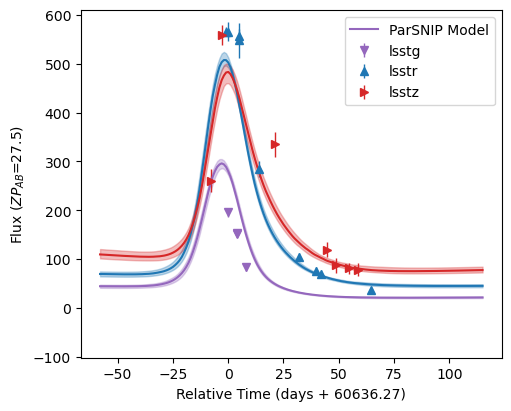

In [150]:
parsnip.plot_light_curve(test_dataset.light_curves[0], model9)

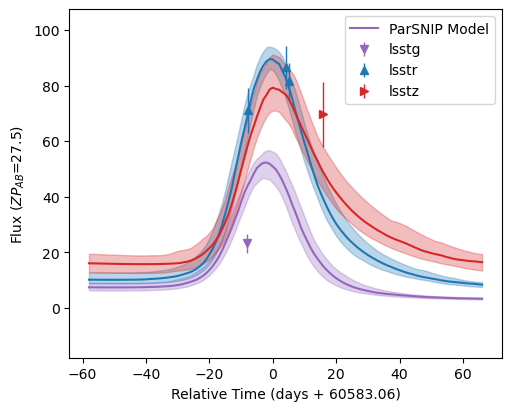

In [152]:
parsnip.plot_light_curve(test_dataset.light_curves[15], model9)

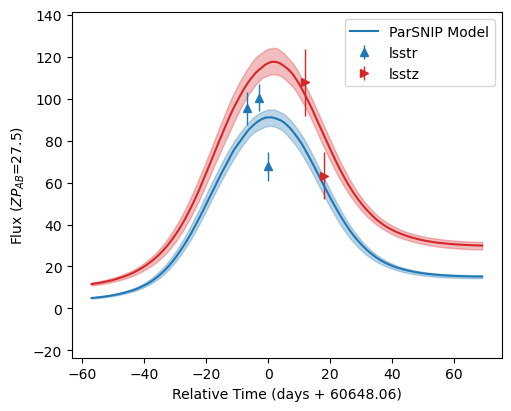

In [151]:
parsnip.plot_light_curve(test_dataset.light_curves[3], model)

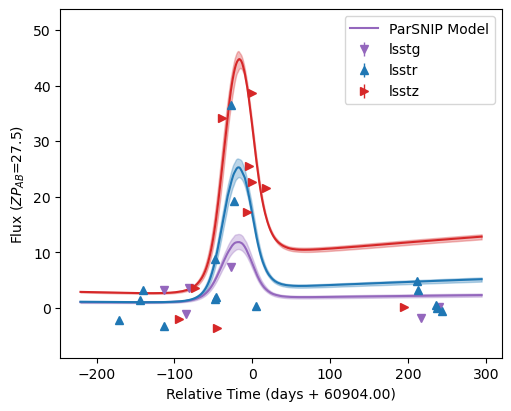

In [21]:
parsnip.plot_light_curve(test_dataset.light_curves[0], model)